# Analyse IMDB Movie Data for Title Segmentation & Reccomendation
[blog title](blog link)

## Introduction
This notebook performs steps 2-5 of October Cloud Guru Challenge as listed here: https://acloudguru.com/blog/engineering/cloudguruchallenge-machine-learning-on-aws

The data used is the IMDB datasets. These can be accessed here: https://datasets.imdbws.com/

Some of the primary libraries used:
* Pandas library for loading and transforming the data (including one-hot-encoding descriptive attributes)
* Sklearn library for scaling and pre-training preparation
* AWS Sagemaker - PCA (for dimension reduction) and KMeans (for k-means cluster analysis)
* MatPlotLib and Seaborn for plotting and exploratory data analysis

Analysis steps based on the following AWS blog:
https://aws.amazon.com/blogs/machine-learning/analyze-us-census-data-for-population-segmentation-using-amazon-sagemaker/

## Dependencies
Some libraries may need to be installed before using

In [1]:
pip install pandas

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install boto3

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install sagemaker

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install mxnet

     |████████████████████████████████| 55.0 MB 57 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import requests
import io
import gzip
import mxnet as mx
import os
import boto3
import sagemaker

from sklearn.preprocessing import MinMaxScaler
from sagemaker import get_execution_role
from sagemaker import PCA
from sagemaker import KMeans

%matplotlib inline
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

## Data Loading
Load the basic title info, alternate title info and title rating info into data frames

In [6]:
def remoteImdbToDf(dataset):
    url="https://datasets.imdbws.com/" + dataset + ".tsv.gz"
    content=requests.get(url).content
    open(dataset + '.tsv.gz', 'wb').write(content)
    
    with gzip.open(dataset + '.tsv.gz', 'rb') as read_file:
        file_content = read_file.read()
        write_file = open(dataset + '.tsv', 'wb')
        write_file.write(file_content)
        write_file.close()
    
    return pd.read_csv(dataset + '.tsv', sep='\t')
    

In [7]:
df_titleakas = remoteImdbToDf('title.akas')

In [8]:
df_titlebasics = remoteImdbToDf('title.basics')

In [9]:
df_titleratings = remoteImdbToDf('title.ratings')

## Exploratory data analysis EDA – Data cleaning and exploration

In [10]:
df_titlebasics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7284078 entries, 0 to 7284077
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   tconst          object
 1   titleType       object
 2   primaryTitle    object
 3   originalTitle   object
 4   isAdult         int64 
 5   startYear       object
 6   endYear         object
 7   runtimeMinutes  object
 8   genres          object
dtypes: int64(1), object(8)
memory usage: 500.2+ MB


In [11]:
# make the column names lower case to make it easier to work with
df_titlebasics.columns = ['titleid','type','title','originaltitle','isadult','startyear','endyear','length','genres']

In [12]:
df_titlebasics.head()

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short"
1,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short"
2,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance"
3,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short"
4,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short"


In [13]:
# we're probably only going to want titles that are movies for the recommendation, let's check this field does that
df_titlebasics[df_titlebasics['type']=='movie'].sample(5)

,titleid,type,title,originaltitle,isadult,startyear,endyear,length,genres
153148,tt0157860,movie,Jhinjhinyar Jer,Jhinjhinyar Jer,0,1936,\N,\N,\N
3976495,tt2627848,movie,Chocolate Is Not Better Than Sex,Chocolate Is Not Better Than Sex,0,\N,\N,\N,Comedy
267759,tt0279280,movie,O todos o ninguno,O todos o ninguno,0,1976,\N,45,Documentary
5359587,tt5779746,movie,Catching Summer,Catching Summer,0,2019,\N,136,Comedy
20946,tt0021268,movie,Holiday of St. Jorgen,Prazdnik svyatogo Yorgena,0,1930,\N,83,Comedy


In [14]:
# make the column names lower case to make it easier to work with
df_titleakas.columns = ['titleid','ordering','title','region','language','types','attributes','isoriginaltitle']

In [15]:
df_titleakas.sample(5)

,titleid,ordering,title,region,language,types,attributes,isoriginaltitle
10924939,tt1632995,7,Épisode #1.94,FR,fr,\N,\N,0
8408632,tt12554300,1,Episódio #1.16,PT,pt,\N,\N,0
21409250,tt8501990,4,Épisode #1.4,FR,fr,\N,\N,0
2635294,tt0901270,6,Folge vom 24. April 2004,DE,de,\N,\N,0
11011667,tt1662775,2,Folge #1.15,DE,de,\N,\N,0


In [16]:
# merge the basic and alternate info data frames on the title id field
df_titlesfull = pd.merge(left=df_titlebasics, right=df_titleakas, left_on='titleid', right_on='titleid')

In [17]:
# we don't need this data anymore, all required info is in the new data frame
del df_titlebasics
del df_titleakas

In [18]:
df_titlesfull.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0


In [19]:
df_titleratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085900 entries, 0 to 1085899
Data columns (total 3 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   tconst         1085900 non-null  object 
 1   averageRating  1085900 non-null  float64
 2   numVotes       1085900 non-null  int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 24.9+ MB


In [20]:
# make the column names lower case to make it easier to work with
df_titleratings.columns = ['titleid', 'averagerating', 'numvotes']

(array([  3812.,   8137.,  18153.,  38631.,  86629., 171559., 279629.,
        297322., 149031.,  32997.]),
 array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ]),
 <a list of 10 Patch objects>)

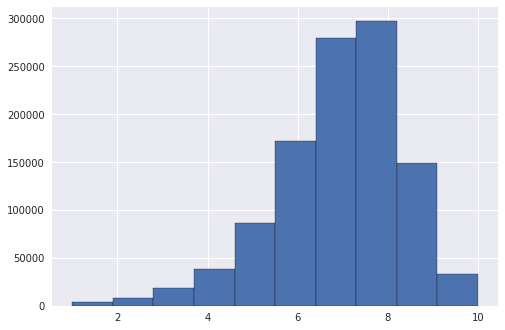

In [21]:
# let's check out the frequency of each rating
plt.hist(df_titleratings['averagerating'], edgecolor='black')

In [22]:
df_titleratings.sample(5)

,titleid,averagerating,numvotes
626558,tt1703125,5.8,2509
657217,tt1885812,9.8,6
14926,tt0032162,6.6,168
880588,tt5065346,4.7,313
247403,tt0473398,5.1,430


In [23]:
# merge the title info and ratings data frames on the title id field
df_titles = pd.merge(left=df_titlesfull, right=df_titleratings, left_on='titleid', right_on='titleid')

In [24]:
# we don't need this data anymore, all required info is in the new data frame
del df_titleratings
del df_titlesfull

In [25]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1655
1,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",2,Carmencita,DE,\N,\N,literal title,0,5.6,1655
2,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",3,Carmencita - spanyol tánc,HU,\N,imdbDisplay,\N,0,5.6,1655
3,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",4,Καρμενσίτα,GR,\N,imdbDisplay,\N,0,5.6,1655
4,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",5,Карменсита,RU,\N,imdbDisplay,\N,0,5.6,1655
5,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",6,Carmencita,US,\N,\N,\N,0,5.6,1655
6,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",7,Carmencita,\N,\N,original,\N,1,5.6,1655
7,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",8,カルメンチータ,JP,ja,imdbDisplay,\N,0,5.6,1655
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,199
9,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",2,A bohóc és kutyái,HU,\N,imdbDisplay,\N,0,6.1,199


In [26]:
df_titles.shape

(2964302, 18)

In [27]:
# the titles get duplicated if it's moved language/region, etc. Let's only consider original titles to remove bias
df_titles = df_titles.drop_duplicates(subset=['titleid'])

In [28]:
df_titles.head(15)

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
0,tt0000001,short,Carmencita,Carmencita,0,1894,\N,1,"Documentary,Short",1,Карменсіта,UA,\N,imdbDisplay,\N,0,5.6,1655
8,tt0000002,short,Le clown et ses chiens,Le clown et ses chiens,0,1892,\N,5,"Animation,Short",1,Le clown et ses chiens,\N,\N,original,\N,1,6.1,199
16,tt0000003,short,Pauvre Pierrot,Pauvre Pierrot,0,1892,\N,4,"Animation,Comedy,Romance",1,Sarmanul Pierrot,RO,\N,imdbDisplay,\N,0,6.5,1366
25,tt0000004,short,Un bon bock,Un bon bock,0,1892,\N,12,"Animation,Short",1,Un bon bock,\N,\N,original,\N,1,6.2,121
33,tt0000005,short,Blacksmith Scene,Blacksmith Scene,0,1893,\N,1,"Comedy,Short",10,Blacksmith Scene,\N,\N,original,\N,1,6.2,2149
44,tt0000006,short,Chinese Opium Den,Chinese Opium Den,0,1894,\N,1,Short,1,Китайский опиумный притон,RU,\N,imdbDisplay,\N,0,5.3,115
50,tt0000007,short,Corbett and Courtney Before the Kinetograph,Corbett and Courtney Before the Kinetograph,0,1894,\N,1,"Short,Sport",1,Corbett and Courtney Before the Kinetograph,US,\N,\N,\N,0,5.5,659
59,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,Edison Kinetoscopic Record of a Sneeze,0,1894,\N,1,"Documentary,Short",10,Edison kinetoskopische Aufnahme eines Niesens,DE,\N,\N,literal title,0,5.4,1820
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
73,tt0000010,short,Leaving the Factory,La sortie de l'usine Lumière à Lyon,0,1895,\N,1,"Documentary,Short",10,Радници напуштају фабрику Лимијер,RS,\N,imdbDisplay,\N,0,6.9,6074


In [29]:
df_titles.shape

(808887, 18)

In [30]:
# now let's get only movies
df_titles = df_titles[df_titles['type']=='movie']

In [31]:
df_titles.shape

(254121, 18)

In [32]:
df_titles.head()

,titleid,type,title_x,originaltitle,isadult,startyear,endyear,length,genres,ordering,title_y,region,language,types,attributes,isoriginaltitle,averagerating,numvotes
69,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance,1,Miss Jerry,\N,\N,original,\N,1,5.9,155
998,tt0000335,movie,Soldiers of the Cross,Soldiers of the Cross,0,1900,\N,\N,"Biography,Drama",1,Early Christian Martyrs,AU,\N,working,\N,0,6.1,40
1406,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N,1,Bohemios,ES,\N,\N,\N,0,3.8,6
1545,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Biography,Crime,Drama",1,Kelly bandájának története,HU,\N,imdbDisplay,\N,0,6.1,593
1634,tt0000615,movie,Robbery Under Arms,Robbery Under Arms,0,1907,\N,\N,Drama,1,Robbery Under Arms,AU,\N,\N,\N,0,4.5,14


In [33]:
# let's drop some of the columns that won't contribute much to the clustering
#  (reconsider region later if needed, obviously need to one-hot-encode it and remove \N values)
df_titles.drop(['originaltitle','ordering','title_y','type',
                'types','region','types','attributes',
                'isoriginaltitle','endyear'],axis=1,inplace=True)

In [34]:
df_titles.shape

(254121, 9)

In [35]:
df_titles.head()

,titleid,title_x,isadult,startyear,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.1,40
1406,tt0000502,Bohemios,0,1905,100,\N,\N,3.8,6
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,593
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [36]:
# make the column names lower case to make it easier to work with, rename some columns due to merge naming
df_titles.columns = ['titleid', 'title', 'isadult',
                     'year','length','genres',
                     'language','averagerating',
                     'numvotes']

In [37]:
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.1,40
1406,tt0000502,Bohemios,0,1905,100,\N,\N,3.8,6
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,593
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14


In [38]:
df_titles.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 254121 entries, 69 to 2964279
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   titleid        254121 non-null  object 
 1   title          254121 non-null  object 
 2   isadult        254121 non-null  int64  
 3   year           254121 non-null  object 
 4   length         254121 non-null  object 
 5   genres         254121 non-null  object 
 6   language       254121 non-null  object 
 7   averagerating  254121 non-null  float64
 8   numvotes       254121 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 19.4+ MB


In [39]:
# let's not consider any titles that don't have a valid year value
df_titles = df_titles[(df_titles['year']!='\\N')]

In [40]:
#  convert the year value (string) to integer for easy scaling and comparison
df_titles['year'] = df_titles['year'].astype(int)

<BarContainer object of 126 artists>

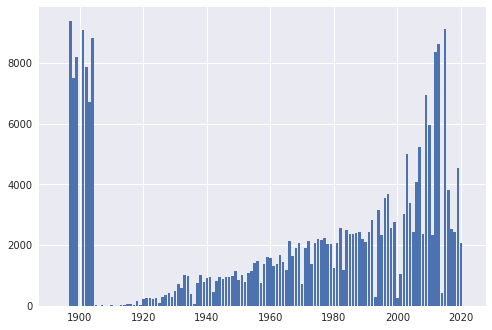

In [41]:
# let's check how many titles are there for each year
plt.bar(df_titles.year.unique(),
        df_titles.year.value_counts().sort_index())

Text(0, 0.5, 'average rating of movie')

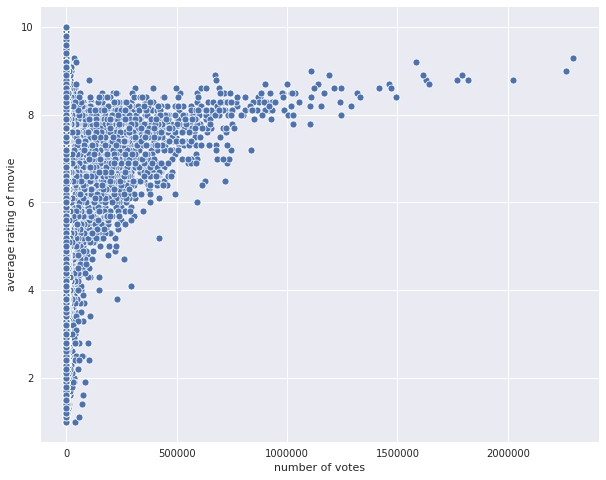

In [42]:
# and check out if there's a relationship between number of votes and the average rating
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['numvotes'], y = df_titles['averagerating'])
plt.xlabel('number of votes')
plt.ylabel('average rating of movie')

Text(0.5, 0, 'year')

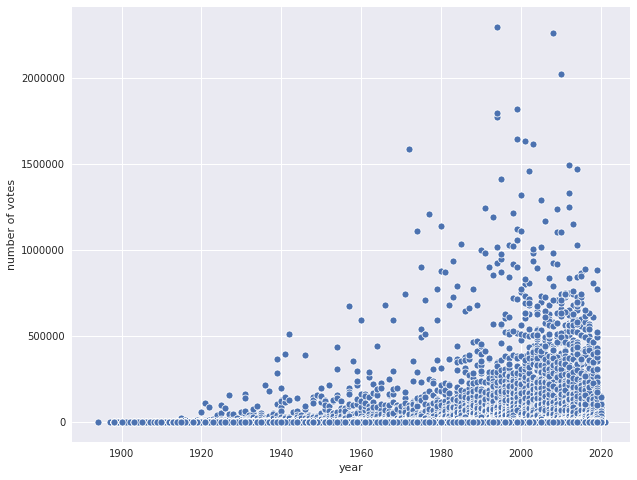

In [43]:
# plot number of votes per movie based on year of release
plt.figure(figsize = (10,8))
sns.scatterplot(x = df_titles['year'], y = df_titles['numvotes'])
plt.ylabel('number of votes')
plt.xlabel('year')

## Data modelling

The 'genres' column contains non-numerical comma-separated-values for zero, one or multiple genres for the title. To make this value comparible (and useful for clustering), this needs to be made into a numerical (0 or 1) for each value. To do this, we need to use a process called 'one-hot-encoding' 

In [44]:
# we can see there's lots of unique values, as each genre can be combined with others
df_titles.genres.unique()

array(['Romance', 'Biography,Drama', '\\N', ..., 'Musical,Mystery,Sci-Fi',
       'Fantasy,History,War', 'Documentary,Family,Sci-Fi'], dtype=object)

In [45]:
df_titles.shape

(254101, 9)

In [46]:
# let's convert the csv column to a pandas list object in a new column
df_titles['genres_list'] = df_titles.genres.str.split(',').tolist()
df_titles.head()

,titleid,title,isadult,year,length,genres,language,averagerating,numvotes,genres_list
69,tt0000009,Miss Jerry,0,1894,45,Romance,\N,5.9,155,[Romance]
998,tt0000335,Soldiers of the Cross,0,1900,\N,"Biography,Drama",\N,6.1,40,"[Biography, Drama]"
1406,tt0000502,Bohemios,0,1905,100,\N,\N,3.8,6,[\N]
1545,tt0000574,The Story of the Kelly Gang,0,1906,70,"Biography,Crime,Drama",\N,6.1,593,"[Biography, Crime, Drama]"
1634,tt0000615,Robbery Under Arms,0,1907,\N,Drama,\N,4.5,14,[Drama]


In [47]:
df_titles.shape

(254101, 10)

In [48]:
# get the one hot encoded values for genre. 
# (this table is relatively sparse)
genres_one_hot_encoded = df_titles.genres_list.str.join('|').str.get_dummies().add_prefix('genre_')
genres_one_hot_encoded.head()

,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Family,...,genre_Reality-TV,genre_Romance,genre_Sci-Fi,genre_Short,genre_Sport,genre_Talk-Show,genre_Thriller,genre_War,genre_Western,genre_\N
69,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
998,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1406,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1545,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1634,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, genres_one_hot_encoded], axis=1, sort=False)

In [50]:
# get the one hot encoded values for language. 
language_one_hot_encoded = pd.get_dummies(df_titles.language, prefix='language')
language_one_hot_encoded.head()

,language_\N,language_af,language_ar,language_az,language_bg,language_bn,language_bs,language_ca,language_cmn,language_cs,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
69,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1406,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1545,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1634,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
# let's add these new columns to the original full data
df_titles = pd.concat([df_titles, language_one_hot_encoded], axis=1, sort=False)

In [52]:
# now we can drop the descriptive value columns, and the one-hot-encoded columns for null values
df_titles.drop(['genres','language','genres_list','genre_\\N','language_\\N'],axis=1,inplace=True)

In [53]:
df_titles.titleid.unique().shape

(254101,)

In [54]:
df_titles.titleid.shape

(254101,)

In [55]:
df_titles.title.unique().shape

(227543,)

In [56]:
df_titles.title.shape

(254101,)

In [57]:
# We can now set the ‘titleid and title’ 
#   as the index and the rest of the numerical 
#   features become the attributes of each unique title.
df_titles.index=df_titles['titleid'] + " " + df_titles['title']
df_titles.drop(['titleid','title'],axis=1,inplace=True)

In [58]:
# Let's get rid of titles where the length value isn't available
df_titles = df_titles[df_titles['length'] != '\\N']

# and conver the length to integer for scale/comparison ease
df_titles['length'] = df_titles['length'].astype(int)

In [59]:
# Remove some really short/long titles, lowly rated, and old movies
df_titles = df_titles[
    (df_titles['length'] > 30) & 
    (df_titles['length'] < 360) &  
    (df_titles['numvotes'] > 50000) &
    (df_titles['year'] > 1960) &
    (df_titles['averagerating'] > 5.0)
]

### Feature engineering

In [60]:
# Data Scaling – We need to standardize the scaling of the numerical columns 
#   in order to use any distance based analytical methods so that we can 
#   compare the relative distances between different feature columns. We can 
#   use minmaxscaler to transform the numerical columns so that they also 
#   fall between 0 and 1.
scaler=MinMaxScaler()
df_titles_scaled=pd.DataFrame(scaler.fit_transform(df_titles))
df_titles_scaled.columns=df_titles.columns
df_titles_scaled.index=df_titles.index

In [61]:
df_titles_scaled.describe()

,isadult,year,length,averagerating,numvotes,genre_Action,genre_Adult,genre_Adventure,genre_Animation,genre_Biography,...,language_te,language_th,language_tl,language_tr,language_uk,language_ur,language_yi,language_yue,language_zh,language_zu
count,3174.0,3174.000000,3174.000000,3174.000000,3174.000000,3174.000000,3174.0,3174.000000,3174.000000,3174.000000,...,3174.000000,3174.000000,3174.000000,3174.000000,3174.0,3174.000000,3174.0,3174.000000,3174.0,3174.0
mean,0.0,0.730843,0.176756,0.433080,0.061937,0.332073,0.0,0.252363,0.059546,0.073724,...,0.000315,0.001260,0.000315,0.028355,0.0,0.000315,0.0,0.001575,0.0,0.0
std,0.0,0.195117,0.081889,0.185135,0.092450,0.471031,0.0,0.434437,0.236682,0.261362,...,0.017750,0.035483,0.017750,0.166012,0.0,0.017750,0.0,0.039665,0.0,0.0
min,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
25%,0.0,0.644068,0.119048,0.309524,0.010652,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
50%,0.0,0.779661,0.162698,0.428571,0.028921,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
75%,0.0,0.881356,0.218254,0.571429,0.073817,1.000000,0.0,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
max,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,0.0


In [62]:
df_titles_scaled.shape

(3174, 96)

In [63]:
# Get the current service/execution role (ensure it has Sagemaker execute permissions)
role = get_execution_role()

In [64]:
# Update this value to your own bucket, the execution role will need R/W access
bucket_name='simontest-2020-10-24'
num_components=95

pca_SM = PCA(role=role,
          train_instance_count=1,
          train_instance_type='ml.c4.xlarge',
          output_path='s3://'+ bucket_name +'/titles/',
            num_components=num_components)

In [65]:
#convert the numerical values to 32 bit floats for consistancy
train_data = df_titles_scaled.values.astype('float32')

In [66]:
%%time
# We call the fit function on our PCA model, passing in our training data, 
# and this spins up a training instance or cluster to perform the training job.
pca_SM.fit(pca_SM.record_set(train_data))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-27 00:24:05 Starting - Starting the training job...
2020-10-27 00:24:07 Starting - Launching requested ML instances......
2020-10-27 00:25:34 Starting - Preparing the instances for training......
2020-10-27 00:26:13 Downloading - Downloading input data...
2020-10-27 00:27:03 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/27/2020 00:27:06 INFO 140559673214784] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-conf.json: {u'_num_gpus': u'auto', u'_log_level': u'info', u'subtract_mean': u'true', u'force_dense': u'true', u'epochs': 1, u'algorithm_mode': u'regular', u'extra_components': u'-1', u'_kvstore': u'dist_sync', u'_num_kv_servers': u'auto'}
[10/27/2020 00:27:06 INFO 140559673214784] Merging with provided configuration from /opt/ml/input/config/hyperparameters.json: {u'feature_dim': u'96', u'mini_batch_

In [67]:
# Get the model artifacts from S3 after they have been trained
job_name=pca_SM._current_job_name
model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

2304

In [68]:
# load the ND array using MXNet
pca_model_params = mx.ndarray.load('model_algo-1')

In [69]:
s=pd.DataFrame(pca_model_params['s'].asnumpy())
v=pd.DataFrame(pca_model_params['v'].asnumpy())

In [70]:
#We can now calculate the variance explained by the largest n components that we want to keep. 
# For this example, let's take the top 20 components.
#We can see that the largest 20 components explain ~91% of the total variance in our dataset:
s.iloc[75:,:].apply(lambda x: x*x).sum()/s.apply(lambda x: x*x).sum()

0    0.922776
dtype: float32

In [71]:
s_20=s.iloc[75:,:]
v_20=v.iloc[:,75:]
v_20.columns=[0,1,2,3,4,5,6,7,8,
              9,10,11,12,13,14,
              15,16,17,18,19]

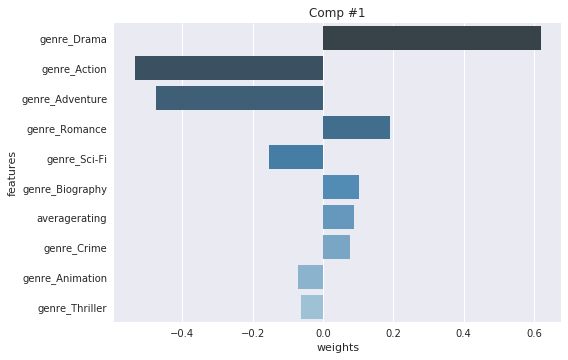

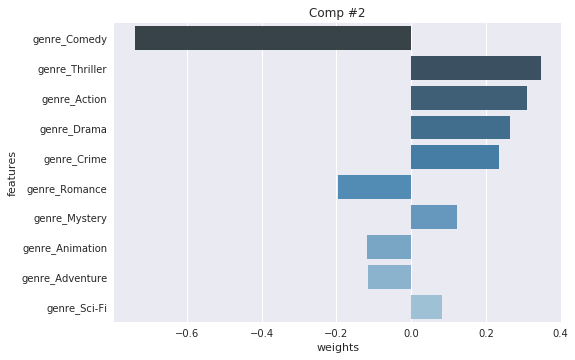

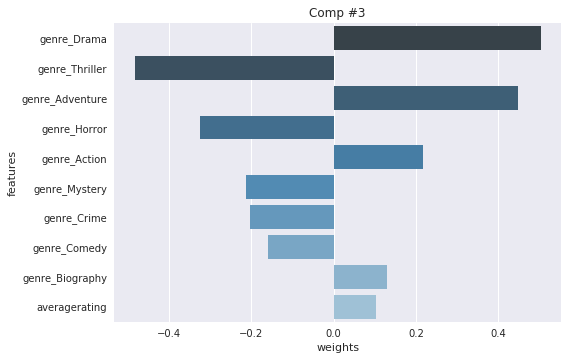

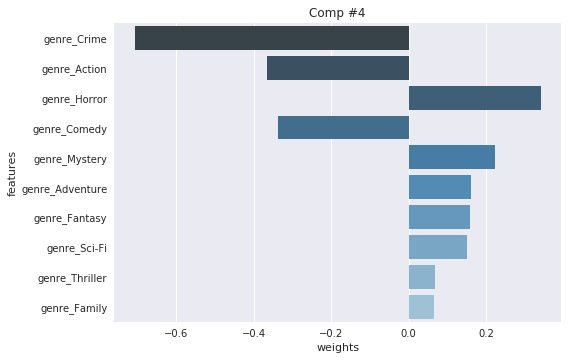

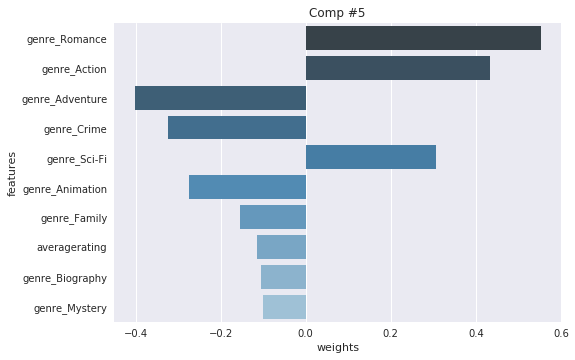

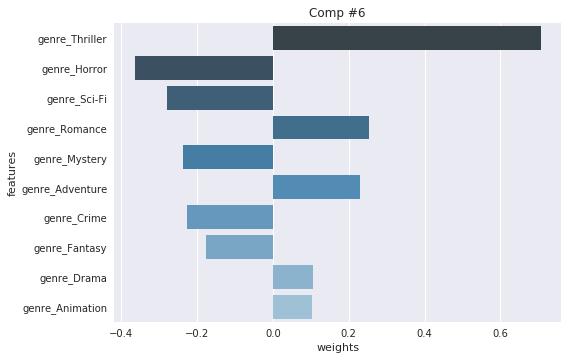

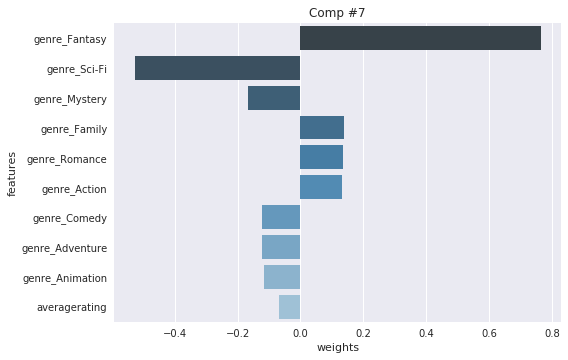

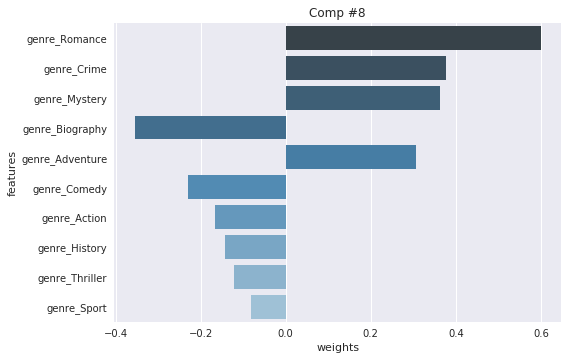

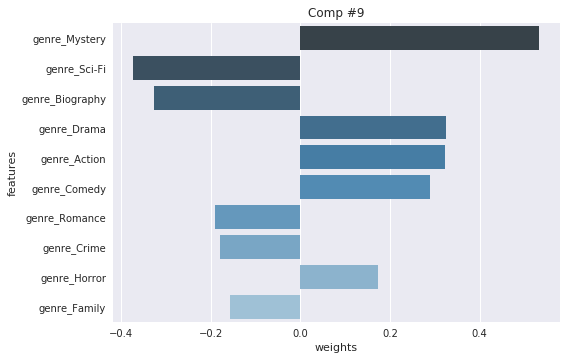

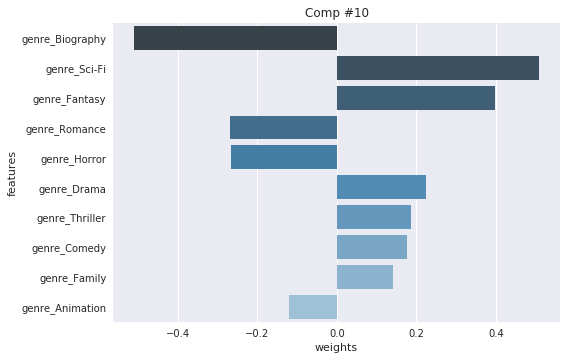

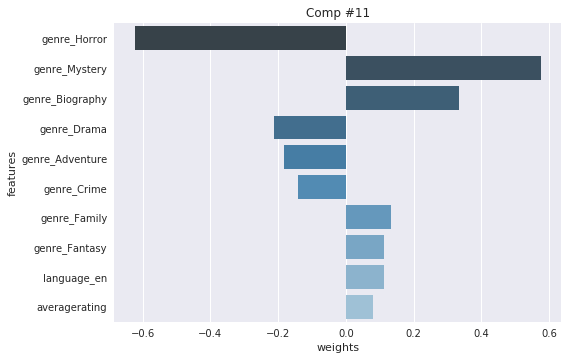

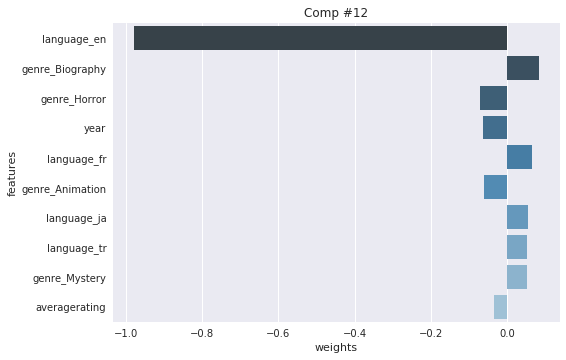

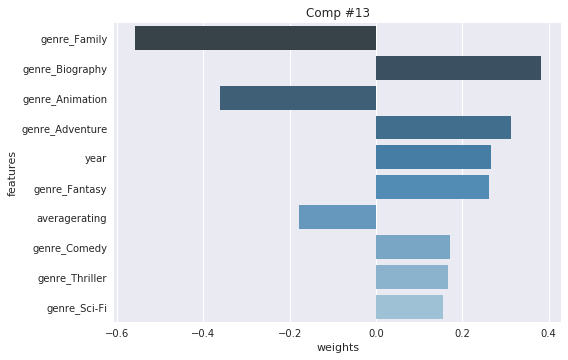

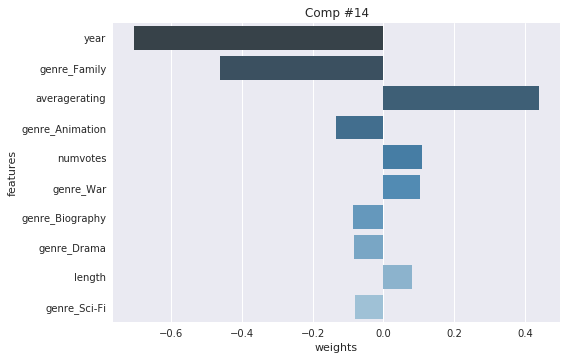

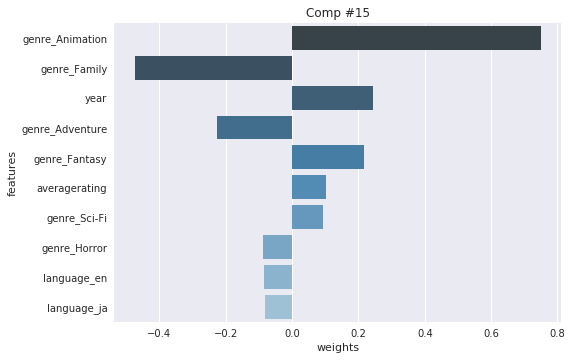

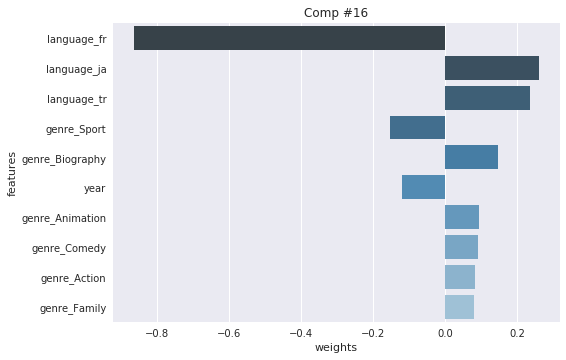

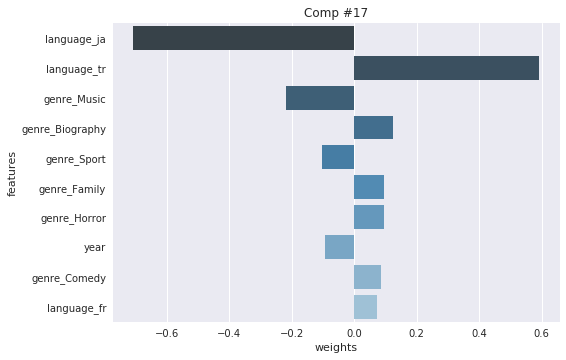

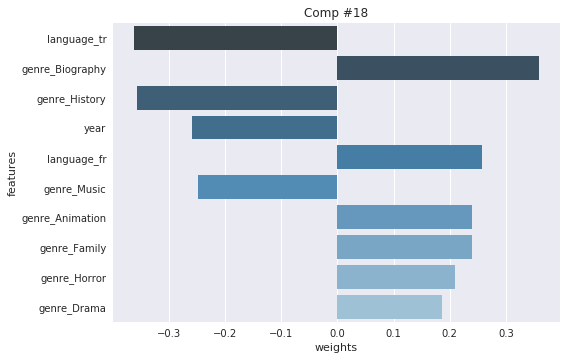

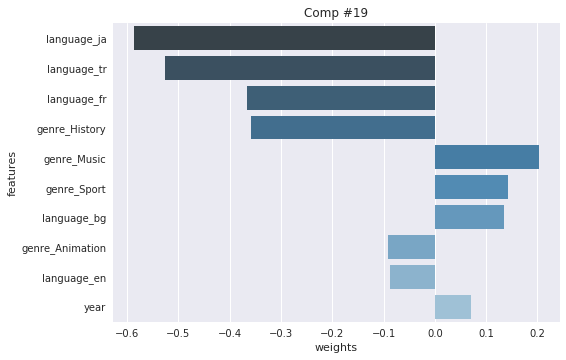

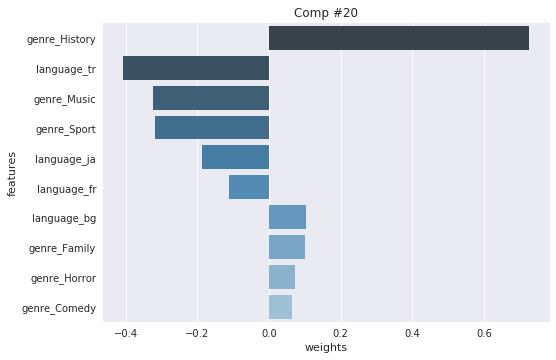

In [127]:
with plt.style.context('seaborn'):
    fig.suptitle('PCA Components Makeup')
    component_num = 1
    for i in range(5):
        for j in range(4):
            comps = pd.DataFrame(list(zip(v_20[20 - component_num], df_titles_scaled.columns)), columns=['weights', 'features'])
            comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
            axes = sns.barplot(data=comps.sort_values('abs_weights', ascending=False).head(10), x="weights", y="features", palette="Blues_d")
            axes.set_title("Comp #"+str(component_num))
            component_num += 1
            plt.show() 
          

In [128]:
#Will need to review this as the data will change over time
PCA_list=['Romance/Drama', 'Crime/Action/Thriller', 'Adventure/Drama', 'Horror/Mystery',
          'Action/Romance', 'Thriller/Romance', 'Fantasy', 'Romance/Mystery/Crime', 'Mystery/Drama/Comedy',
          'Sci-Fi/Fantasy', 'Mystery/Bio', 'Non-EN-Lang', 'Recent/Bio/Adventure', 
          'Classics', 'Recent/Fantasy/Animation', 'JA-Lang/TR-Lang', 'TR-Lang/Bio',
          'Bio/Older/FR-Lang', 'Music/Sport', 'History']

In [129]:
%%time
pca_predictor = pca_SM.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


---------------!CPU times: user 278 ms, sys: 10.7 ms, total: 289 ms
Wall time: 7min 33s


In [130]:
%%time
result = pca_predictor.predict(train_data)
df_titles_transformed=pd.DataFrame()
for a in result:
    b=a.label['projection'].float32_tensor.values
    df_titles_transformed=df_titles_transformed.append([list(b)])
df_titles_transformed.index=df_titles_scaled.index
df_titles_transformed=df_titles_transformed.iloc[:,75:]
df_titles_transformed.columns=PCA_list

CPU times: user 22.3 s, sys: 0 ns, total: 22.3 s
Wall time: 22.6 s


In [131]:
df_titles_transformed.head()

,Romance/Drama,Crime/Action/Thriller,Adventure/Drama,Horror/Mystery,Action/Romance,Thriller/Romance,Fantasy,Romance/Mystery/Crime,Mystery/Drama/Comedy,Sci-Fi/Fantasy,Mystery/Bio,Non-EN-Lang,Recent/Bio/Adventure,Classics,Recent/Fantasy/Animation,JA-Lang/TR-Lang,TR-Lang/Bio,Bio/Older/FR-Lang,Music/Sport,History
tt0035423 Kate & Leopold,0.062631,-0.036209,0.082194,0.037738,0.064674,0.177910,0.139445,0.263915,0.049821,0.200427,0.144523,-0.312404,0.347319,0.813331,0.005702,0.490845,0.096162,-0.300564,-1.053828,0.123870
tt0054698 Breakfast at Tiffany's,0.064057,-0.024343,0.340285,0.149032,0.172782,-0.164297,0.606618,-0.171090,0.082179,-0.120747,0.005665,0.006272,0.261652,-0.022426,0.304849,0.502791,-0.092882,0.172784,-0.721984,0.837028
tt0054997 The Hustler,-0.404462,0.101204,-0.083463,-0.089061,-0.147740,-0.257411,0.650420,-0.415853,-0.899686,0.089376,0.068017,-0.148666,-0.248196,-0.071585,-0.022065,-0.110508,0.200298,0.320229,0.214316,0.639001
tt0055031 Judgment at Nuremberg,-0.042965,-0.087139,-0.073822,-0.047551,-0.011893,-0.221385,0.768908,-0.438412,-0.930330,0.047832,0.109432,-0.117214,-0.197431,-0.070195,-0.000508,-0.108974,0.206286,0.340758,0.238377,0.639750
tt0055254 One Hundred and One Dalmatians,-0.001062,-0.063977,0.278837,0.093790,0.150999,0.354185,0.527948,-0.304318,0.052723,-0.150806,-0.098013,-0.044873,0.116801,-0.349868,0.273510,-0.718198,0.115701,0.112487,-1.033234,-0.526929


In [132]:
train_data = df_titles_transformed.values.astype('float32')

In [133]:
#If the number of clusters is high, hopefully we get better recommendations
num_clusters = 40
kmeans = KMeans(role=role,
                train_instance_count=1,
                train_instance_type='ml.c4.xlarge',
                output_path='s3://'+ bucket_name +'/titles/',              
                k=num_clusters)

In [134]:
%%time
kmeans.fit(kmeans.record_set(train_data))

'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.


2020-10-27 02:08:13 Starting - Starting the training job...
2020-10-27 02:08:15 Starting - Launching requested ML instances......
2020-10-27 02:09:24 Starting - Preparing the instances for training.........
2020-10-27 02:11:00 Downloading - Downloading input data...
2020-10-27 02:11:43 Training - Training image download completed. Training in progress.
2020-10-27 02:11:43 Uploading - Uploading generated training model.Docker entrypoint called with argument(s): train
Running default environment configuration script
[10/27/2020 02:11:40 INFO 140025374865216] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_ll

In [135]:
%%time
kmeans_predictor = kmeans.deploy(initial_instance_count=1, 
                                 instance_type='ml.t2.medium')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-----------------!CPU times: user 303 ms, sys: 8.38 ms, total: 312 ms
Wall time: 8min 32s


In [136]:
%%time
result=kmeans_predictor.predict(train_data)

CPU times: user 210 ms, sys: 0 ns, total: 210 ms
Wall time: 583 ms


In [137]:
cluster_labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in result]
pd.DataFrame(cluster_labels)[0].value_counts()

4.0     192
22.0    178
2.0     159
7.0     136
0.0     130
8.0     129
11.0    123
18.0    114
14.0    114
19.0    103
5.0     103
29.0    100
10.0     94
15.0     94
26.0     88
12.0     82
6.0      81
23.0     79
17.0     78
9.0      77
1.0      65
13.0     64
25.0     63
33.0     62
21.0     60
27.0     59
20.0     58
32.0     57
24.0     56
16.0     50
39.0     48
3.0      47
38.0     46
30.0     37
31.0     34
28.0     33
34.0     28
36.0     21
35.0     20
37.0     12
Name: 0, dtype: int64

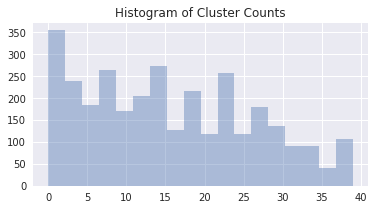

In [138]:
ax=plt.subplots(figsize=(6,3))
ax=sns.distplot(cluster_labels, kde=False)
title="Histogram of Cluster Counts"
ax.set_title(title, fontsize=12)
plt.show()

## Drawing conclusions from our modelling

In [139]:
#job_name='<your_SageMaker_KMeans_job_name_here>'
job_name=kmeans._current_job_name

model_key = "titles/" + job_name + "/output/model.tar.gz"

boto3.resource('s3').Bucket(bucket_name).download_file(model_key, 'model.tar.gz')
os.system('tar -zxvf model.tar.gz')
os.system('unzip model_algo-1')

Kmeans_model_params = mx.ndarray.load('model_algo-1')

In [140]:
cluster_centroids=pd.DataFrame(Kmeans_model_params[0].asnumpy())
cluster_centroids.columns=df_titles_transformed.columns
cluster_centroids

,Romance/Drama,Crime/Action/Thriller,Adventure/Drama,Horror/Mystery,Action/Romance,Thriller/Romance,Fantasy,Romance/Mystery/Crime,Mystery/Drama/Comedy,Sci-Fi/Fantasy,Mystery/Bio,Non-EN-Lang,Recent/Bio/Adventure,Classics,Recent/Fantasy/Animation,JA-Lang/TR-Lang,TR-Lang/Bio,Bio/Older/FR-Lang,Music/Sport,History
0,-0.004420,-0.013774,-0.031757,-0.005613,-0.017783,-0.052908,-0.010283,0.144590,0.002841,0.003857,0.221203,-0.272817,0.133006,-0.488512,-0.214380,0.269301,0.201255,0.465104,0.215588,-1.175385
1,-0.011379,-0.026036,-0.130028,0.043958,0.003355,-0.019489,0.055423,-0.042850,0.021209,-0.295079,0.051417,-0.170139,0.286487,0.033109,-0.259804,-0.348224,-0.441324,0.075738,0.451729,0.641380
2,-0.063684,0.028360,-0.167745,-0.055325,-0.079409,-0.029147,0.104910,-0.022609,0.035078,0.113691,0.064062,-0.048226,-0.247822,-0.152060,-0.103656,0.035243,-0.071799,-0.346006,-0.758665,-0.073646
3,0.002772,0.003415,0.022981,-0.031030,0.013911,0.192519,0.018405,0.149904,-0.023780,-0.153796,0.355491,0.018215,-0.046548,0.719482,-0.321774,-0.218471,0.550820,0.272878,0.156445,0.417351
4,-0.058072,0.009724,-0.187970,-0.059955,-0.069688,-0.019722,0.052174,-0.232394,-0.085875,-0.034923,0.051817,-0.009343,-0.084217,-0.044021,0.021202,-0.160265,0.236571,0.363022,0.170344,0.525867
5,0.013517,0.007735,0.028606,0.048278,0.021914,-0.051825,-0.040449,0.092722,-0.017962,-0.252232,-0.165505,0.049568,-0.052189,-0.027755,0.070639,-0.086244,0.726295,-1.126833,0.423278,-0.125614
6,0.008462,-0.004285,-0.020421,-0.002869,0.030761,0.044743,-0.000797,-0.053804,0.027345,0.022893,-0.044988,-0.217244,0.101985,0.145899,0.291948,-0.016419,-0.719085,-0.705436,0.775138,-0.482459
7,-0.028536,0.032911,-0.020382,-0.006516,0.006348,0.012526,-0.024017,-0.065016,-0.001359,-0.016973,-0.232497,-0.162812,0.491928,0.069159,0.188114,0.496293,0.252056,0.340337,0.052476,0.745599
8,0.051545,-0.031324,0.147609,0.046897,0.009368,-0.030193,-0.005838,0.061506,-0.034642,-0.101225,-0.028124,0.111267,0.238866,-0.003533,0.286196,0.546142,-0.103484,0.150165,-0.728531,0.795324
9,-0.026140,0.010015,-0.052409,-0.016266,-0.050333,0.091552,0.112893,0.258057,0.026859,0.104694,0.113996,-0.025927,0.142704,0.795211,-0.114308,-0.118392,0.226707,0.468898,0.046876,-1.068196


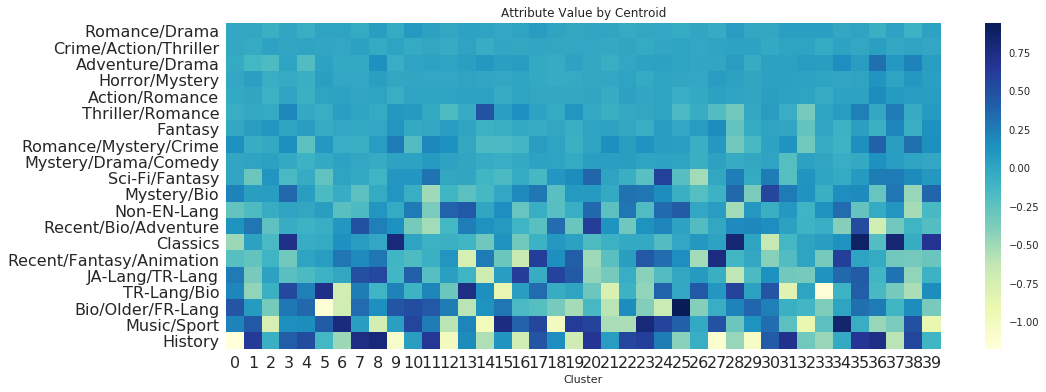

In [141]:
plt.figure(figsize = (16, 6))
ax = sns.heatmap(cluster_centroids.T, cmap = 'YlGnBu')
ax.set_xlabel("Cluster")
plt.yticks(fontsize = 16)
plt.xticks(fontsize = 16)
ax.set_title("Attribute Value by Centroid")
plt.show()

In [142]:
df_titles_transformed['labels']=list(map(int, cluster_labels))
df_titles_transformed.head()

,Romance/Drama,Crime/Action/Thriller,Adventure/Drama,Horror/Mystery,Action/Romance,Thriller/Romance,Fantasy,Romance/Mystery/Crime,Mystery/Drama/Comedy,Sci-Fi/Fantasy,...,Non-EN-Lang,Recent/Bio/Adventure,Classics,Recent/Fantasy/Animation,JA-Lang/TR-Lang,TR-Lang/Bio,Bio/Older/FR-Lang,Music/Sport,History,labels
tt0035423 Kate & Leopold,0.062631,-0.036209,0.082194,0.037738,0.064674,0.177910,0.139445,0.263915,0.049821,0.200427,...,-0.312404,0.347319,0.813331,0.005702,0.490845,0.096162,-0.300564,-1.053828,0.123870,18
tt0054698 Breakfast at Tiffany's,0.064057,-0.024343,0.340285,0.149032,0.172782,-0.164297,0.606618,-0.171090,0.082179,-0.120747,...,0.006272,0.261652,-0.022426,0.304849,0.502791,-0.092882,0.172784,-0.721984,0.837028,8
tt0054997 The Hustler,-0.404462,0.101204,-0.083463,-0.089061,-0.147740,-0.257411,0.650420,-0.415853,-0.899686,0.089376,...,-0.148666,-0.248196,-0.071585,-0.022065,-0.110508,0.200298,0.320229,0.214316,0.639001,4
tt0055031 Judgment at Nuremberg,-0.042965,-0.087139,-0.073822,-0.047551,-0.011893,-0.221385,0.768908,-0.438412,-0.930330,0.047832,...,-0.117214,-0.197431,-0.070195,-0.000508,-0.108974,0.206286,0.340758,0.238377,0.639750,4
tt0055254 One Hundred and One Dalmatians,-0.001062,-0.063977,0.278837,0.093790,0.150999,0.354185,0.527948,-0.304318,0.052723,-0.150806,...,-0.044873,0.116801,-0.349868,0.273510,-0.718198,0.115701,0.112487,-1.033234,-0.526929,14


In [143]:
cluster=df_titles_transformed[df_titles_transformed['labels']==20]
cluster.sample(10)

,Romance/Drama,Crime/Action/Thriller,Adventure/Drama,Horror/Mystery,Action/Romance,Thriller/Romance,Fantasy,Romance/Mystery/Crime,Mystery/Drama/Comedy,Sci-Fi/Fantasy,...,Non-EN-Lang,Recent/Bio/Adventure,Classics,Recent/Fantasy/Animation,JA-Lang/TR-Lang,TR-Lang/Bio,Bio/Older/FR-Lang,Music/Sport,History,labels
tt0486822 Disturbia,0.016624,0.039717,-0.039077,-0.007356,0.010174,-0.004134,-0.068178,0.046970,0.071407,0.353747,...,0.377594,0.624870,-0.168114,-0.491458,-0.462964,-0.285575,-0.143999,0.567090,0.715916,20
tt0061811 In the Heat of the Night,0.013842,-0.001416,0.158483,0.076846,0.113781,-0.126361,0.540014,-0.184585,0.110008,0.354823,...,0.269768,0.629150,-0.195565,-0.474758,-0.526307,-0.277192,-0.123890,0.574753,0.750740,20
tt2273657 True Story,-0.015090,-0.040238,-0.040240,-0.017215,-0.024845,-0.068610,-0.215381,0.139589,-0.912404,0.456145,...,0.398480,0.581252,-0.179247,-0.495524,-0.446454,-0.294560,-0.151051,0.558414,0.706057,20
tt0454848 Inside Man,0.028318,0.042897,-0.033967,0.006318,0.022645,0.008079,0.041252,0.009827,0.066118,0.373228,...,0.350362,0.619461,-0.182794,-0.482067,-0.486125,-0.285644,-0.117622,0.580106,0.733370,20
tt1175709 All Good Things,0.012141,0.040165,-0.053824,-0.020603,-0.002439,-0.005736,-0.165978,0.082509,0.072827,0.342888,...,0.400219,0.627367,-0.157058,-0.497251,-0.446106,-0.286264,-0.158845,0.560332,0.705785,20
tt0071877 Murder on the Orient Express,0.011779,0.001605,0.107183,0.051364,0.083388,-0.135650,0.379019,-0.120384,0.104803,0.350094,...,0.297642,0.623083,-0.184238,-0.482266,-0.499125,-0.282307,-0.133832,0.573822,0.736838,20
tt0117381 Primal Fear,0.024132,0.030641,0.012151,0.022678,0.044054,-0.033069,0.164280,-0.038597,0.076960,0.368917,...,0.329780,0.618738,-0.185756,-0.479985,-0.495103,-0.284931,-0.118758,0.579779,0.739040,20
tt0181689 Minority Report,0.037488,0.015324,-0.024307,-0.004240,0.056621,0.053201,0.197300,-0.208568,0.076070,0.634367,...,0.336392,0.536306,-0.011784,-0.626229,-0.062894,-0.609626,-0.398035,0.630168,-0.419921,20
tt1399683 Winter's Bone,-0.026670,0.074736,-0.096866,-0.040799,-0.016251,0.049333,-0.023020,-0.080069,0.083409,0.501304,...,0.553093,0.244373,-0.180815,-0.261438,-0.147807,0.420273,0.066473,0.334126,0.646210,20
tt0070723 Soylent Green,0.024026,-0.053536,0.073794,0.046672,0.078624,-0.033000,0.362098,-0.029227,0.134481,0.544382,...,-0.394147,0.728282,-0.667848,-0.869718,-0.196650,-0.091487,-0.602177,0.383998,-0.039591,20


In [144]:
# merge the title info and ratings data frames on the title id field
df_titles_clustered = pd.merge(left=df_titles, right=df_titles_transformed, left_index=True, right_index=True)

In [145]:
df_titles_clustered.to_csv("clustered_titles.csv")

In [146]:
sagemaker.Session().delete_endpoint(pca_predictor.endpoint)

In [147]:
sagemaker.Session().delete_endpoint(kmeans_predictor.endpoint)

In [148]:
boto3.resource('s3').Bucket(bucket_name).upload_file("clustered_titles.csv", "titles/clustered_titles.csv")